0 : 636553.1798022955
tensor([-0.5055, -1.0596, -0.1526])
100 : 26212.49491031766
tensor([-0.4183, -1.0154, -0.0761])
200 : 33189.588138309125
tensor([-0.3326, -0.9831, -0.0068])
300 : 130.12687450051308
tensor([-0.2451, -0.9660,  0.0622])
400 : 13679.614886653422
tensor([-0.1711, -0.9359,  0.1171])
500 : 110346.29184545872
tensor([-0.1074, -0.9209,  0.1596])
600 : 13957.486779391764
tensor([-0.0420, -0.9059,  0.1985])
700 : 5401.093806153536
tensor([ 0.0138, -0.9013,  0.2310])
800 : 237.47495296895508
tensor([ 0.0678, -0.8779,  0.2508])
900 : 194.63409640491008
tensor([ 0.1045, -0.8732,  0.2594])
1000 : 12.617400696873663
tensor([ 0.1384, -0.8389,  0.2662])
1100 : 13.900038662552834
tensor([ 0.1788, -0.8080,  0.2902])
1200 : 17.54261501133442
tensor([ 0.2149, -0.7844,  0.3066])
1300 : 1216.1019395619633
tensor([ 0.2344, -0.7718,  0.3084])
1400 : 12.422961482405663
tensor([ 0.2475, -0.7534,  0.3071])
1500 : 6382.296127420664
tensor([ 0.2607, -0.7375,  0.3080])
1600 : 6.956501740217209


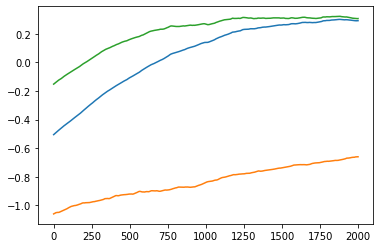

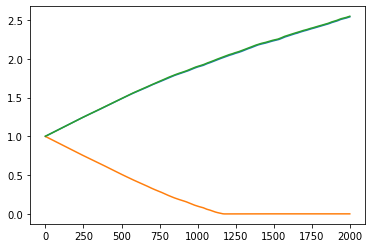

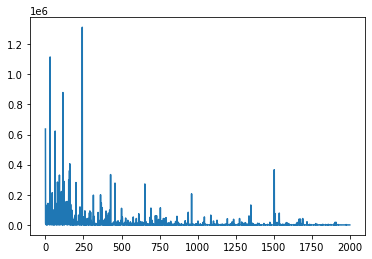

0 : 21.528373107910163, 52.15589883327484
100 : 36.86217222929001, 13.696393504142762
200 : 33.60213438272477, 26.833688886165618
300 : 10.50636190533638, 36.83291116714478
400 : 40.61642772078514, 43.08729459047318
500 : 32.9030867254734, 23.756234157085423
600 : 48.08526164054871, 20.013102152347567
700 : 31.94042211651802, 69.19898824214934
800 : 39.85606779575348, 39.28810159444809
900 : 11.945990598201751, 49.08996870279313
1000 : 6.740918277502059, 147.88315527439116
1100 : 14.005829069614412, 52.640995697975164
1200 : 12.155276411771775, 34.524158139228824
1300 : 13.382217807769774, 9.867532107830048
1400 : 31.358530527353288, 28.10192805767059
1500 : 11.633672758340838, 52.93658213376999
1600 : 52.604353281259534, 27.866814630031588
1700 : 14.007046318054199, 62.181402046680454
1800 : 20.722090497016907, 79.55006939888001
1900 : 11.958104530572893, 14.861412959098814
0 : 16.548123688697814, 94.20641951560975
100 : 15.63636865615845, 26.03711647748947
200 : 20.515135650634765, 7

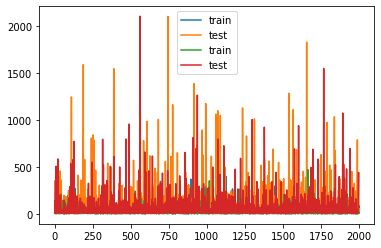

In [1]:
import operator
import torch
import pyro
import torch.nn as nn
import pyro.distributions as dist
import matplotlib.pyplot as plt
from functools import reduce
from itertools import accumulate
from pyro.infer import SVI, Trace_ELBO
from convolution import conv

class nn_add_vc(nn.Module):
    def __init__(self, state_dim, latent_dim):
        super().__init__()
        self.layer_1 = nn.Linear(state_dim+1, latent_dim)
        self.layer_2 = nn.Linear(latent_dim, latent_dim)
        self.layer_3 = nn.Linear(latent_dim, state_dim)
        self.sequential = nn.Sequential(self.layer_1, nn.ReLU(),
                                        self.layer_2, nn.ReLU(),
                                        self.layer_3)

    def forward(self, v: torch.Tensor, c: torch.Tensor):
        return self.sequential(torch.cat([v,c],-1))

class nn_add_vc_b(nn.Module):
    def __init__(self, state_dim, latent_dim):
        super().__init__()
        self.layer_1 = nn.Linear(state_dim+1, latent_dim)
        self.layer_2 = nn.Linear(latent_dim, latent_dim)
        self.layer_3 = nn.Linear(latent_dim, state_dim)
        self.sequential = nn.Sequential(self.layer_1, nn.ReLU(),
                                        self.layer_2, nn.ReLU(),
                                        self.layer_3)

    def forward(self, v: torch.Tensor, c: torch.Tensor):
        return self.sequential(torch.cat([v,c],-1))

class nn_add_vv(nn.Module):
    def __init__(self, state_dim, latent_dim):
        super().__init__()
        self.layer_1 = nn.Linear(state_dim*2, latent_dim)
        self.layer_2 = nn.Linear(latent_dim, latent_dim)
        self.layer_3 = nn.Linear(latent_dim, state_dim)
        self.sequential = nn.Sequential(self.layer_1, nn.ReLU(),
                                        self.layer_2, nn.ReLU(),
                                        self.layer_3)

    def forward(self, v1: torch.Tensor, v2: torch.Tensor):
        return self.sequential(torch.cat([v1,v2],-1))

class nn_add_vv_b(nn.Module):
    def __init__(self, state_dim, latent_dim):
        super().__init__()
        self.layer_1 = nn.Linear(state_dim*2, latent_dim)
        self.layer_2 = nn.Linear(latent_dim, latent_dim)
        self.layer_3 = nn.Linear(latent_dim, state_dim)
        self.sequential = nn.Sequential(self.layer_1, nn.ReLU(),
                                        self.layer_2, nn.ReLU(),
                                        self.layer_3)

    def forward(self, v_result: torch.Tensor, v_1: torch.Tensor, v_2: torch.Tensor):
        return (self.sequential(v_result, v_1), self.sequential(v_result, v_2))

class nn_mult_vc(nn.Module):
    def __init__(self, state_dim, latent_dim):
        super().__init__()
        self.layer_1 = nn.Linear(state_dim+1, latent_dim)
        self.layer_2 = nn.Linear(latent_dim, latent_dim)
        self.layer_3 = nn.Linear(latent_dim, state_dim)
        self.sequential = nn.Sequential(self.layer_1, nn.ReLU(),
                                        self.layer_2, nn.ReLU(),
                                        self.layer_3)

    def forward(self, v: torch.Tensor, c: torch.Tensor):
        return self.sequential(torch.cat([v,c],-1))

class nn_mult_vc_b(nn.Module):
    def __init__(self, state_dim, latent_dim):
        super().__init__()
        self.layer_1 = nn.Linear(state_dim+1, latent_dim)
        self.layer_2 = nn.Linear(latent_dim, latent_dim)
        self.layer_3 = nn.Linear(latent_dim, state_dim)
        self.sequential = nn.Sequential(self.layer_1, nn.ReLU(),
                                        self.layer_2, nn.ReLU(),
                                        self.layer_3)

    def forward(self, v: torch.Tensor, c: torch.Tensor):
        return self.sequential(torch.cat([v,c],-1))

class nn_mult_vv(nn.Module):
    def __init__(self, state_dim, latent_dim):
        super().__init__()
        self.layer_1 = nn.Linear(state_dim * 2, latent_dim)
        self.layer_2 = nn.Linear(latent_dim, latent_dim)
        self.layer_3 = nn.Linear(latent_dim, state_dim)
        self.sequential = nn.Sequential(self.layer_1, nn.ReLU(),
                                        self.layer_2, nn.ReLU(),
                                        self.layer_3)

    def forward(self, v1: torch.Tensor, v2: torch.Tensor):
        return self.sequential(torch.cat([v1,v2],-1))

class nn_mult_vv_b(nn.Module):
    def __init__(self, state_dim, latent_dim):
        super().__init__()
        self.layer_1 = nn.Linear(state_dim * 2, latent_dim)
        self.layer_2 = nn.Linear(latent_dim, latent_dim)
        self.layer_3 = nn.Linear(latent_dim, state_dim)
        self.sequential = nn.Sequential(self.layer_1, nn.ReLU(),
                                        self.layer_2, nn.ReLU(),
                                        self.layer_3)

    def forward(self, v_result: torch.Tensor, v_1: torch.Tensor, v_2: torch.Tensor):
        return (self.sequential(v_result, v_1), self.sequential(v_result, v_2))

class nn_obs_b(nn.Module):
    def __init__(self, state_dim, latent_dim, component_num = 5):
        super().__init__()
        self.component_num = component_num
        self.layer_1 = nn.Linear(state_dim + 1, latent_dim)
        self.layer_2 = nn.Linear(latent_dim, latent_dim)
        self.layer_3 = nn.Linear(latent_dim, 3 * component_num)
        self.sequential = nn.Sequential(self.layer_1, nn.ReLU(),
                                        self.layer_2, nn.ReLU(),
                                        self.layer_3)
    
    def forward(self, v: torch.Tensor, obs: torch.Tensor):
        result = self.sequential(torch.cat([v, obs], -1))
        categorical, mean, scale = result.split(self.component_num)
        return dist.MixtureSameFamily(dist.Categorical(categorical ** 2 + 1), dist.Normal(mean, scale ** 2 + 1))

class nn_poly(nn.Module):
    
    def __init__(self, state_dim: int, latent_dim: int):
        super().__init__()
        self.state_dim = state_dim
        self.nn_add_vc = nn_add_vc(state_dim, latent_dim)
        self.nn_add_vc_b = nn_add_vc_b(state_dim, latent_dim)
        self.nn_add_vv = nn_add_vv(state_dim, latent_dim)
        self.nn_add_vv_b = nn_add_vv_b(state_dim, latent_dim)
        self.nn_mult_vc = nn_mult_vc(state_dim, latent_dim)
        self.nn_mult_vc_b = nn_mult_vc_b(state_dim, latent_dim)
        self.nn_mult_vv = nn_mult_vv(state_dim, latent_dim)
        self.nn_mult_vv_b = nn_mult_vv_b(state_dim, latent_dim)
        self.nn_obs_b = nn_obs_b(state_dim, latent_dim)
    
    def forward(self, coeffs : torch.FloatTensor, obs: float):
        leading_coeffs = len(coeffs)
        state = torch.ones(self.state_dim, dtype=torch.float)
        powers = [state]
        for _ in range(leading_coeffs - 2):
            powers.insert(0, self.nn_mult_vv(powers[0], state))

        power_tensor = torch.stack(powers)
        term_tensor = self.nn_mult_vc(power_tensor, coeffs[:-1].unsqueeze(1))
        
        indetermine_state = reduce(self.nn_add_vv.forward, term_tensor)
        final_state = self.nn_add_vc(indetermine_state, coeffs[-1].unsqueeze(0))

        return self.nn_obs_b(final_state, torch.tensor([obs]))


# Models
def univariate_polynomial(coeffs: torch.FloatTensor, obs: float):
    u = pyro.sample("variable", dist.Normal(0, 1))
    power = torch.arange(0, len(coeffs)).float()
    poly = torch.sum((u ** power) * coeffs)
    return pyro.sample("observed", dist.Normal(poly, 1), obs = torch.tensor(obs))

def bivariate_polynomial(coeffs: torch.FloatTensor, obs:float):
    pass


# Guides
# nn_guide = nn_poly(10, 20)
component_num = 3
state = 5
conv_guide = nn_obs_b(state, state * 20, component_num)
mult_guide = nn_obs_b(state, state * 20, component_num)

def constant_state(operator_, base):
    if operator_ == operator.mul:
        return torch.ones_like(base)
    elif operator_ == conv:
        constant_state_ = torch.zeros_like(base)
        constant_state_[0] = 1
        return constant_state_

def poly_state(coeffs: torch.FloatTensor, base: torch.Tensor, operator = operator.mul):
    constant_state_ = constant_state(operator, base)
    conv_list = [constant_state_] + [base] * (len(coeffs) - 1)
    stacked_states = torch.stack(list(accumulate(conv_list, operator)))
    return (stacked_states * coeffs.unsqueeze(1)).sum(0)

def guide_mixture(coeffs: torch.FloatTensor, obs: float):
    categorical = pyro.param("categorical", torch.ones(component_num))
    mean = pyro.param("mean", torch.randn(component_num))
    scale = pyro.param("scale", torch.randn(component_num))
    return pyro.sample("variable", dist.MixtureSameFamily(dist.Categorical(categorical ** 2 + 1),dist.Normal(mean, scale ** 2 + 1)))

def guide_mult(coeffs: torch.FloatTensor, obs: float):
    normal_base = pyro.param("normal_base_mult", torch.ones(state) * 0.1)
    poly_result = poly_state(coeffs, normal_base, operator.mul)

    pyro.module("nn_mult", mult_guide)
    return pyro.sample("variable", mult_guide(poly_result, obs = torch.tensor([obs])))

def guide_conv(coeffs: torch.FloatTensor, obs: float):
    normal_base = pyro.param("normal_base_conv", torch.ones(state) * 0.1)
    poly_result = poly_state(coeffs, normal_base, conv)

    pyro.module("nn_conv", conv_guide)
    return pyro.sample("variable", conv_guide(poly_result, obs = torch.tensor([obs])))


# Runs
def run_mixture(num_step: int, test_set: list[tuple[torch.Tensor]]) -> None:
    pyro.clear_param_store()
    means = []
    categoricals = []
    losses_t = []
    coeffs_t, obs_t = test_set[0]
    svi_mixture = SVI(univariate_polynomial, guide_mixture, pyro.optim.ClippedAdam({"lr": 0.001}), Trace_ELBO(20))

    for step in range(num_step):
        losses_t.append(svi_mixture.step(coeffs_t, obs_t))
        means.append(pyro.get_param_store().get_param("mean").clone().detach())
        categoricals.append(pyro.get_param_store().get_param("categorical").clone().detach())
        if step % 100 == 0:
            print(f"{step} : {losses_t[-1]}")
            print(pyro.get_param_store().get_param("mean").clone().detach())

    plt.plot(torch.stack(means))
    plt.show()
    plt.plot(torch.stack(categoricals))
    plt.show()
    plt.plot(losses_t)
    plt.show()


def run_mult(num_step: int, train_set: list[tuple[torch.Tensor]], test_set: list[tuple[torch.Tensor]]) -> None:
    pyro.clear_param_store()
    mult_losses_train = []
    mult_losses_test = []
    svi_mult = SVI(univariate_polynomial, guide_mult, pyro.optim.ClippedAdam({"lr": 0.00001}), Trace_ELBO(5))

    try:
        for step in range(num_step):
            loss_train = 0
            for coeffs_, obs_ in train_set:
                loss_train += svi_mult.step(coeffs_, obs_)
            mult_losses_train.append(loss_train / len(train_set))

            loss_test = 0
            for coeffs_, obs_ in test_set:
                loss_test += svi_mult.evaluate_loss(coeffs_, obs_)
            mult_losses_test.append(loss_test / len(test_set))

            if step % 100 == 0:
                print(f"{step} : {mult_losses_train[-1]}, {mult_losses_test[-1]}")
    except:
        print(coeffs_, obs_, guide_mult(coeffs_, obs_))

    plt.plot(mult_losses_train, label = "train")
    plt.plot(mult_losses_test, label = "test")


def run_conv(num_step: int, train_set: list[tuple[torch.Tensor]], test_set: list[tuple[torch.Tensor]]) -> None:
    pyro.clear_param_store()
    conv_losses_train = []
    conv_losses_test = []
    svi_conv = SVI(univariate_polynomial, guide_conv, pyro.optim.ClippedAdam({"lr": 0.00001}), Trace_ELBO(5))

    for step in range(num_step):
        loss_train = 0
        for coeffs_, obs_ in train_set:
            loss_train += svi_conv.step(coeffs_, obs_)
        conv_losses_train.append(loss_train / len(train_set))

        loss_test = 0
        for coeffs_, obs_ in test_set:
            loss_test += svi_conv.evaluate_loss(coeffs_, obs_)
        conv_losses_test.append(loss_test / len(test_set))

        if step % 100 == 0:
            print(f"{step} : {conv_losses_train[-1]}, {conv_losses_test[-1]}")

    plt.plot(conv_losses_train, label = "train")
    plt.plot(conv_losses_test, label = "test")
    plt.legend()


if __name__ == "__main__":
    num_step = 2000
    train_set = [(torch.randn(4)*2, torch.randn(1).item()*2) for _ in range(10)]
    test_set = [(torch.randn(4)*2, torch.randn(1).item()*2) for _ in range(5)]

    run_mixture(num_step, test_set)
    run_mult(num_step, train_set, test_set)
    run_conv(num_step, train_set, test_set)